<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/notebooks/License_Plate_dataset_PCA_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brazilean license plate dataset

The dataset came from: https://web.inf.ufpr.br/vri/databases/ufpr-alpr/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# DATA_ROOT = "./drive/MyDrive/data/UFPR_YOLO"
DATA_ROOT = "./drive/MyDrive/data/Kaggle_license_plates"

# Load the data

## Methods

In [3]:
IMAGE_SIZE = 224

In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [5]:
from lxml import etree
import json

def to_json(path, data):
  """
  save json data to path
  """
  # y_yolov5_lists = y_yolov5.tolist()
  # json_str = json.dumps(y_yolov5_lists)
  with open(path, 'w', encoding='utf-8') as file:
      json.dump(data, file, ensure_ascii=False, indent=4)

def from_json(path):
  """
  save json data to path
  """
  file = open(path, 'r', encoding='utf-8')
  return json.load(file)

def resize_annotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)

    # y_yolov5 = np.array([to_yolov5(y) for y in y_train_raw])
    return [int(xmin), int(ymin), int(xmax), int(ymax)]

def extract_annotations(label_file, class_id):
  labels = []
  with open(label_file, "r") as file:
    count = 0
    for line in file:
      tokens = [float(token) for token in line.split()]
      if tokens[0] == class_id:
        count += 1
        # print(line)
        labels.append(np.array(tokens[1:]))

    if count > 1:
      print("WARNING: More than one license plate was found: ", count, label_file)
    elif count == 0:
      print("WARNING: No license plate was found: ", count, label_file)

  return np.array(labels)

def to_yolov5(y):
  """
  # change to yolo v5 format
  # https://github.com/ultralytics/yolov5/issues/12
  # [x_top_left, y_top_left, x_bottom_right, y_bottom_right] to
  # [x_center, y_center, width, height]
  """
  width = y[2] - y[0]
  height = y[3] - y[1]

  if width < 0 or height < 0:
    print("ERROR: negative width or height ", width, height, y)
    raise AssertionError("Negative width or height")
  return int(y[0] + (width/2)), int(y[1] + (height/2)), width, height

In [6]:
def load_images(path):
  path = os.path.join(path,'*')
  files = glob.glob(path)
  # We sort the images in alphabetical order to match them
  #  to the annotation files
  files.sort()

  X_raw = []
  for file in files:
    image = cv2.imread(file)
    image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
    X_raw.append(np.array(image))

  return np.array(X_raw)

def load_labels(path, yolov5=True):
  """
  if path is an annotation file, just load it
  and return it immediately to save time
  """
  if path.endswith('.json'):
    return from_json(path)

  path = os.path.join(path,'*')
  files = glob.glob(path)
  files.sort()

  y_raw = []
  for file in files:
    if yolov5:
      y_raw.append(extract_annotations(file, 0))
    else:
      y_raw.append(resize_annotation(file))
  return np.array(y_raw)

In [7]:
# transform to arrays and normalize
def normalize(X_raw, y_raw):
  X = np.array(X_raw)
  y = np.array(y_raw)
  y = y.reshape((y.shape[0], -1))

  #  Renormalisation
  X = X / IMAGE_SIZE
  y = y / IMAGE_SIZE

  return X, y

In [8]:
import matplotlib.patches as patches

def create_patch_rectangle(y, color):
  # width = y[2] - y[0]
  # height = y[3] - y[1]
  # return patches.Rectangle((y[0], y[1]),
  #                           width, height,
  #                           edgecolor=color, fill=False)
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)
def plot_images(X, y, limit=10):
  fig = plt.figure(figsize=(20,40))

  # The number of images for plotting is limited to 50
  end_id = len(y) if len(y) < limit else limit

  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.axis('off')
    image = X[i]

    rect_ori = create_patch_rectangle(y[i]*IMAGE_SIZE, (0, 255/255, 0))
    axis.add_patch(rect_ori)
    plt.imshow(np.clip(image, 0, 1))
# plot_images(X_train_d[0], y_train_d[0])

## Execution

### UFPR dataset

In [15]:
X_train_raw = load_images(DATA_ROOT + "/images/train/")
# X_test_raw = load_images(DATA_ROOT + "/images/test/")
# X_val_raw = load_images(DATA_ROOT + "/images/validation/")

y_train_raw = load_labels(DATA_ROOT + "/labels/train/")
# y_val_raw = load_labels(DATA_ROOT + "/labels/validation/")
# y_test_raw = load_labels(DATA_ROOT + "/labels/test/")

In [ ]:
# # from sklearn.model_selection import train_test_split
# # TODO
# X_train_raw = X_raw

X_train, y_train = normalize(X_train_raw, y_train_raw)
# X_val, y_val = normalize(X_val_raw, y_val_raw)
# X_test, y_test = normalize(X_test_raw, y_test_raw)

### Kaggle dataset

In [9]:
X_train_raw = load_images(DATA_ROOT + "/images/")
y_train_raw = load_labels(DATA_ROOT + "/annotations.json")
X_train, y_train = normalize(X_train_raw, y_train_raw)

# Clustering

### Methods

#### PCA

In [36]:
from sklearn.decomposition import PCA

def to_pca(X_train, y_train):
  X_train_flatten = X_train.reshape(X_train.shape[0], -1)

  pca = PCA(2)

  X_train_pca = pca.fit_transform(X_train_flatten)

  # plot the scatter plot along the way
  plt.figure(1)
  plt.clf()

  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="Paired")
  plt.colorbar()

  return X_train_pca

In [49]:
def to_pca_3d(X_train, y_train):
  X_train_flatten = X_train.reshape(X_train.shape[0], -1)

  pca = PCA(3)

  X_train_pca = pca.fit_transform(X_train_flatten)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  # ax = Axes3D(fig)

  ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1],  X_train_pca[:, 2],
              c=y_train, cmap="Paired")
  # ax.colorbar()

  return X_train_pca

In [18]:
from sklearn.cluster import KMeans

def get_clusters(X_train_pca):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_train_pca_clusters = kmeans.fit(X_train_pca)

  return X_train_pca_clusters, kmeans

def get_feature_map_clusters(X, K):
  """
  param X: input data
  param K: number of clusters
  returns: X_clusters - clustered input data

  (side effect): plots the frequency histogram of clusters
  """
  X_fm, _ = get_feature_maps(X)
  # use cosine distance to find similarities
  X_fm_normalized = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

  return get_clusters(X_fm_normalized)

def to_cluster_ids(bins, labels):
  """
  param bins: range of K
  param labels: cluster labels
  returns: dictionary of cluster IDs
  """
  cluster_dict = dict()
  for cluster_id in bins:
    cluster_dict[cluster_id] = np.where(labels == cluster_id)[0]
  return cluster_dict

def to_clusters_dict(X, y, X_clusters, K):
  X_cluster_ids = to_cluster_ids(range(K), X_clusters.labels_)

  X_dict = {}
  y_dict = {}
  for id in range(K):
    ids = X_cluster_ids[id]
    X_dict[id] = X[ids]
    y_dict[id] = y[ids]

  return X_dict, y_dict

In [34]:
def plot_cluster_histogram(X_clusters, K):
  histo_x, bins = np.histogram(X_clusters.labels_, bins=range(K + 1))
  plt.bar(bins[:-1], histo_x, align='center')

def plot_pca_clusters(X_train_pca, kmeans):
  # kmeans, X_train_pca_clusters = get_clusters(X_train_pca)

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
  y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'k.', markersize=2)
  # Plot the centroids as a white X
  centroids = kmeans.cluster_centers_
  plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
              color="w", zorder=10)
  plt.title("K-means clustering on the PCA-reduced data\n"
            "Centroids are marked with white cross")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

In [13]:
from sklearn.model_selection import train_test_split

def partition_on_clusters(X_d, y_d, bins, val_size=0.1, test_size=0.2):
  X_train_d = dict()
  y_train_d = dict()
  X_val_d = dict()
  y_val_d = dict()
  X_test_d = dict()
  y_test_d = dict()

  # for each cluster reserve test_size portion for test data
  for id in bins:
    Xt_train, Xt_test, yt_train, yt_test = \
      train_test_split(X_d[id], y_d[id], test_size=0.2, shuffle=False)
    Xt_train, Xt_val, yt_train, yt_val = \
      train_test_split(Xt_train, yt_train, test_size=0.1, shuffle=False)

    X_train_d[id] = Xt_train
    y_train_d[id] = yt_train

    X_val_d[id] = Xt_val
    y_val_d[id] = yt_val

    X_test_d[id] = Xt_test
    y_test_d[id] = yt_test

  return X_train_d, y_train_d, \
         X_val_d, y_val_d, \
         X_test_d, y_test_d

### Execution

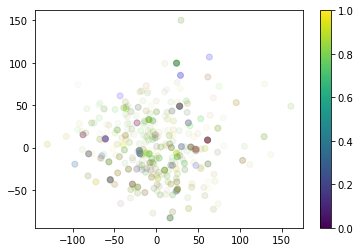

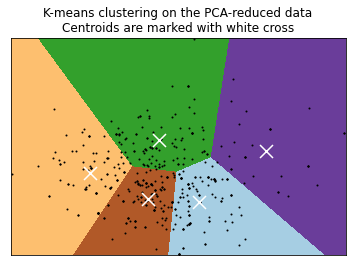

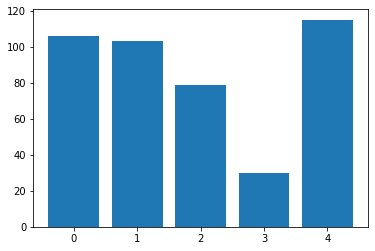

In [38]:
K = 5
X_train_pca = to_pca(X_train, y_train)
X_train_pca_clusters, pca_kmeans = get_clusters(X_train_pca)
plot_pca_clusters(X_train_pca, pca_kmeans)
plot_cluster_histogram(X_train_pca_clusters, K)

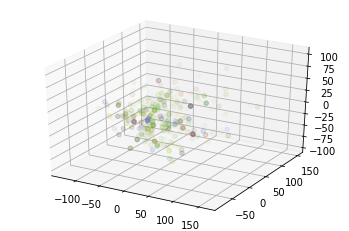

In [50]:
X_train_pca_3d = to_pca_3d(X_train, y_train)


In [22]:
X_train_d, y_train_d = to_clusters_dict(X_train, y_train, X_train_pca_clusters, K)

In [23]:
X_train_d, y_train_d, X_val_d, y_val_d, X_test_d, y_test_d = \
          partition_on_clusters(X_train_d, y_train_d, range(K))

In [ ]:
plot_images(X_train_d[0], y_train_d[0], limit=50)

# Models

## Methods

In [ ]:
def create_model(train_size, probability=True):
  kl_divergence_fn = lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(y_train.shape[0], dtype=tf.float32)

  model = Sequential()
  model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))

  if probability:
    model.add(tfp.layers.DenseFlipout(4, activation="sigmoid", kernel_divergence_fn=kl_divergence_fn))
  else:
    model.add(Dense(4, activation="sigmoid"))

  model.layers[-6].trainable = False
  model.summary()

  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

  return model

# Train

## Methods

In [ ]:
def train(model,
          X_train, y_train,
          X_val, y_val,
          X_test, y_test,
          epochs=50, batch_size=16,
          is_plot_predictions=False):
  train_history = model.fit(x=X_train, y=y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs, batch_size=batch_size, verbose=1,
                            callbacks=[wandb.keras.WandbCallback(data_type="image",
                            save_model=False)])
  # Test
  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Score : %.2f%%" % (scores[1]*100))

  test_loss, test_accuracy = model.evaluate(X_test, y_test, steps=int(100))

  print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

  y_preds = sample_predictions(model, X_test, iterations=1)
  # y_preds = model.predict(X_test)

  # # TODO:
  # # Hack to fix erroneous predictions
  # y_preds = fix_predictions(y_preds)
  if is_plot_predictions:
    plot_predictions(X_test, y_test, y_preds)

  # averaged_predictions = average_sample_preds(y_preds)
  # y_test = np.array([to_rect(y*IMAGE_SIZE) for y in y_test])
  # rectified_predictions = np.array([to_rect(y*IMAGE_SIZE) for y in averaged_predictions])

  # # print(rectified_predictions)
  # m_ap = calculate_map(y_test*IMAGE_SIZE, rectified_predictions*IMAGE_SIZE)
  return model

### Sample predictions

In [ ]:
# run predictions many times to get the distributions
def sample_predictions(model, samples, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(samples).numpy())

    predicted = np.array(predicted)
    # predicted = np.concatenate(predicted, axis=1)

    # predicted = np.array([model_prob.predict(np.expand_dims(X_test[1], [0])) for i in range(iterations)])
    # predicted = np.concatenate(predicted, axis=1)
    reshaped = np.array([predicted[:, column] for column in range(0, predicted.shape[1])])

    return reshaped

def predict_on_cluster(model, X_test, y_test, is_plot_predictions=False, iterations=50):
  test_accuracy = 0
  test_loss, test_accuracy = model.evaluate(X_test, y_test, steps=1)
  y_preds = sample_predictions(model, X_test, iterations=iterations)

  # TODO:
  # Hack to fix erroneous predictions
  # y_preds_fixed = fix_predictions(y_preds)
  if is_plot_predictions:
    plot_predictions(X_test, y_test, y_preds)

  preds_avg = average_sample_preds(y_preds)
  rectified_y_test = np.array([to_rect(y*IMAGE_SIZE) for y in y_test])
  rectified_predictions = np.array([to_rect(y*IMAGE_SIZE) for y in preds_avg])

  m_ap = calculate_map(rectified_y_test*IMAGE_SIZE, rectified_predictions*IMAGE_SIZE)
  stds = np.mean(np.std(y_preds, axis=1), axis=1)

  return y_preds, m_ap, np.mean(stds, axis=0), test_accuracy

In [ ]:
def predict_on_models(X, y, bins, models):
  stats = []
  for model in models:
    cluster_stats = []
    for clst_id in bins:
      # y_preds, m_ap, accuracy, mstd = predict_on_cluster(model, X[clst_ids[clst_id]], y[clst_ids[clst_id]])
      y_preds, m_ap, std, accuracy = predict_on_cluster(model, X[clst_id], y[clst_id])
      print("{} mAP: {:0.2f} std: {:0.2f} acc: {:0.2f}".format(clst_id,
                                                               m_ap['avg_prec'],
                                                               std,
                                                               accuracy))
      cluster_stats.append([np.round(m_ap['avg_prec'], 3), np.round(std, 3), np.round(accuracy, 3)])

    stats.append(cluster_stats)

  return np.array(stats)

## Execution

In [ ]:
X_train = get_merged_data(X_train_d)
y_train = get_merged_data(y_train_d)

X_val = get_merged_data(X_val_d)
y_val = get_merged_data(y_val_d)

X_test = get_merged_data(X_test_d)
y_test = get_merged_data(y_test_d)

In [ ]:
wandb.init(project="UFPR-cnn",
           config={
               "batch_size": 16,
               "learning_rate": 0.01,
               "dataset": "UFPR-cnn",
           })

model_cnn = create_model(y_train.shape[0], probability=False)
model_cnn = train(model_cnn,
                  X_train, y_train,
                  X_val, y_val,
                  X_test, y_test, epochs=100)

In [ ]:
wandb.init(project="UFPR-prob",
           config={
               "batch_size": 16,
               "learning_rate": 0.01,
               "dataset": "UFPR-prob",
           })

model_prob = create_model(y_train.shape[0], probability=True)
model_prob = train(model_prob,
                   X_train, y_train,
                   X_val, y_val,
                   X_test, y_test)

# Predict

## Methods

### Plot predictions

In [ ]:
def plot_predictions(X, y_gt, y_preds):
  fig = plt.figure(figsize=(20,40))

  # The number of images for plotting is limited to 50
  end_id = len(y_gt) if len(y_gt) < 50 else 50

  y_preds_avg = average_sample_preds(y_preds)
  stds = np.std(y_preds, axis=1)
  mean_stds = np.mean(stds, axis=1)

  for i in range(0, end_id):
    axis = fig.add_subplot(10, 5, i+1)
    plt.axis('off')
    image = X[i]

    rect_ori = create_patch_rectangle(y_gt[i]*IMAGE_SIZE, (0, 255/255, 0))
    axis.add_patch(rect_ori)

    # for each test image, there could be multiple predictions
    for y_pred in y_preds[i]:
      rect_pred = create_patch_rectangle(y_pred*IMAGE_SIZE, (255/255, 0, 0))
      axis.add_patch(rect_pred)

    iou = bb_iou(to_rect(y_preds_avg[i]*IMAGE_SIZE), to_rect(y_gt[i]*IMAGE_SIZE))
    plt.title("IOU: {:0.2f} std: {:0.2f}".format(iou, mean_stds[i]))
    # plt.title("mean std: {:0.2f}".format(mean_stds[sample_ids[i]]))
    plt.imshow(np.clip(image, 0, 1))

In [ ]:
def plot_stats(stats, types, titles):
  x_bar = np.arange(K)
  bar_width = .35

  fig = plt.figure(figsize=(20,40))

  for i, stat in zip(range(len(stats)), stats):
    ax = fig.add_subplot(10, 4, i+1)
    # plt.axis('off')

    for t in types:
      if "mAP" == t:
        rects1 = ax.bar(x_bar - bar_width/3, stat[:, 0], label="mAP")
      if "std" == t:
        rects2 = ax.bar(x_bar + bar_width/3, stat[:, 1], label="std")
      if "accuracy" == t:
        rects3 = ax.bar(x_bar + bar_width/3, stat[:, 2], label="accuracy")

    ax.set_xticks(x_bar)
    ax.set_xticklabels(x_bar)
    ax.set_title(titles[i])

    ax.legend()

  fig.tight_layout()

In [ ]:
# plot line graph for comparing different noise level results
def plot_stats_by_type(stats, x_bins, column, title, clusters=bins, merge=False):
  fig = plt.figure(figsize=(20,40))
  ax = fig.add_subplot(10, 4, 1)

  if merge:
    p = ax.plot(x_bins, [np.mean(run) for run in stats_noise[:, :, 1]], label='avg')
  else:
    x_bins_len = len(x_bins)
    for cluster_id in range(len(clusters)):
      p = ax.plot(x_bins, stats[:x_bins_len, :, column][:, cluster_id], label=cluster_id)
    # p = ax.plot(noise_levels, stats[:bins, :, column][:, 0], color='green', label='0')

  ax.set_title(title)
  ax.legend()

## Execution

In [ ]:

_, m_ap, std, accuracy = predict_on_cluster(model_prob, X_test_d[0], y_test_d[0], is_plot_predictions=True, iterations=100)
print("{} mAP: {:0.2f} std: {:0.2f} acc: {:0.2f}".format(0,
                                                          m_ap['avg_prec'],
                                                          std,
                                                          accuracy))
